In [127]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [87]:
df = pd.read_csv('datasets/mammographic-mass.csv')

In [89]:
df

,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


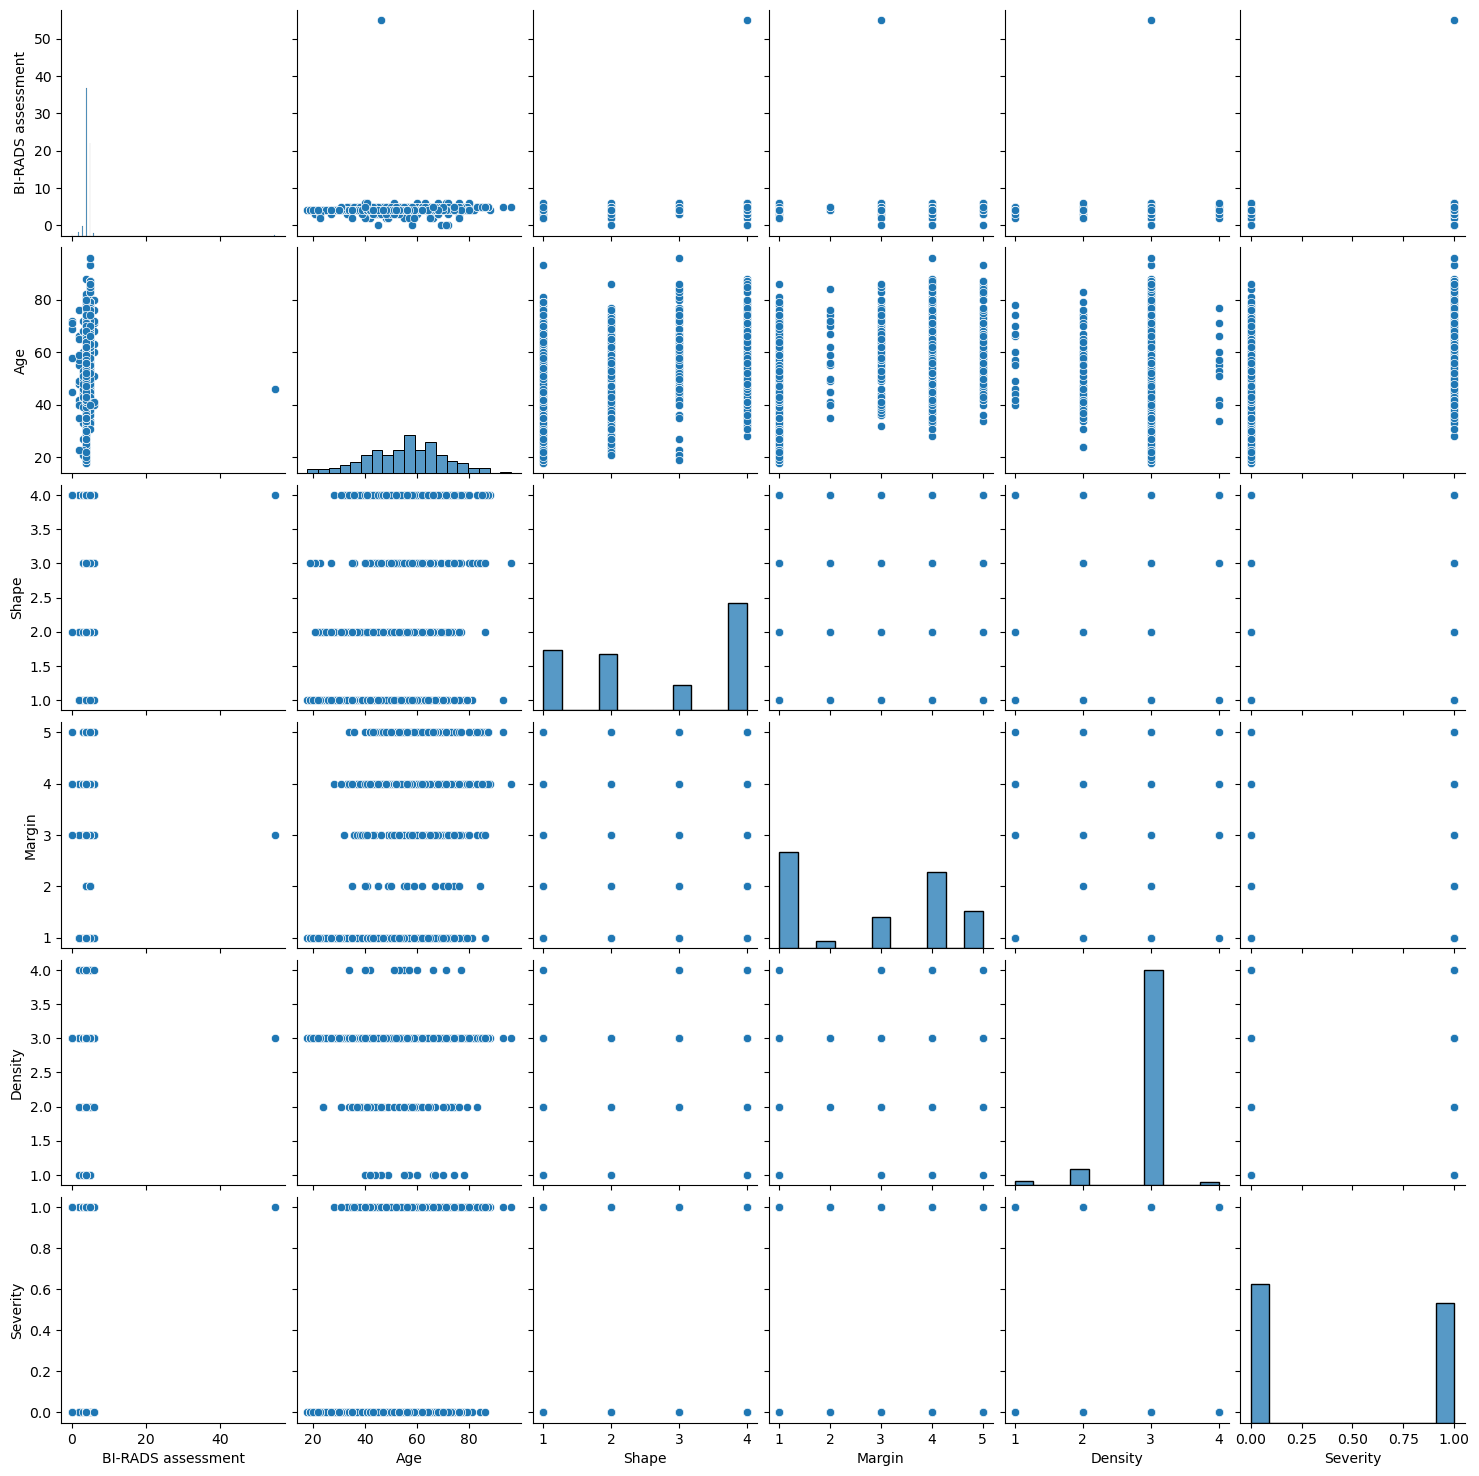

In [91]:
sns.pairplot(df)

<Axes: >

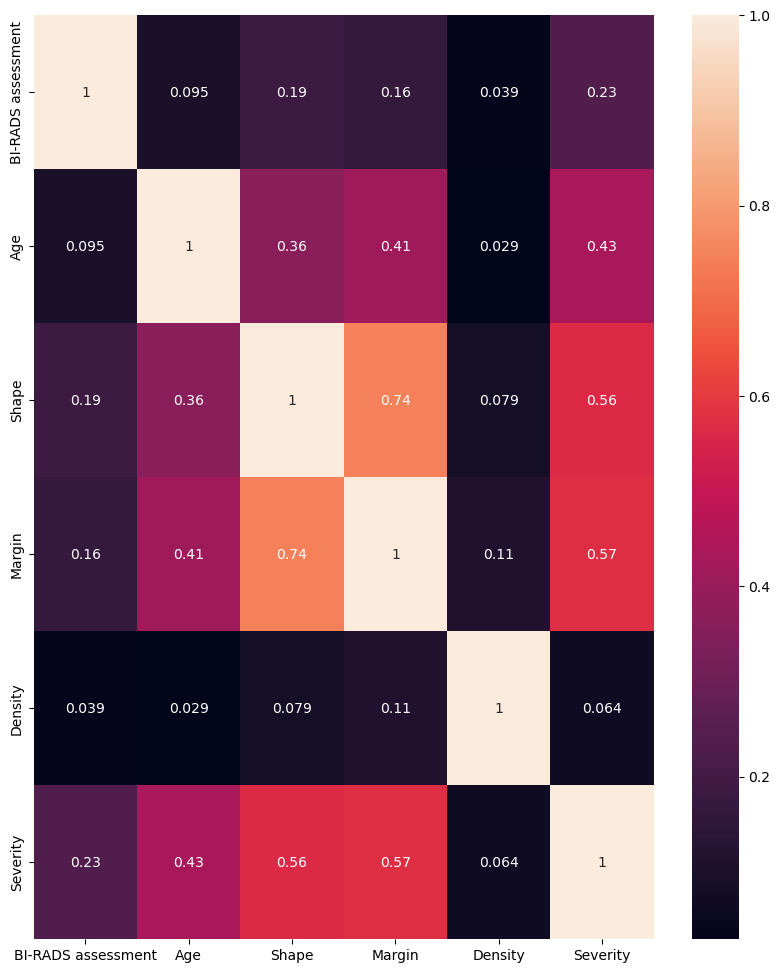

In [92]:
plt.figure(figsize=(10,12))
sns.heatmap(df.corr(), annot=True)

In [95]:
df.isnull().sum()

BI-RADS assessment     2
Age                    5
Shape                 31
Margin                48
Density               76
Severity               0
dtype: int64

In [97]:
mv_percentage = df.isnull().sum() / len(df)
mv_percentage * 100

BI-RADS assessment    0.208117
Age                   0.520291
Shape                 3.225806
Margin                4.994797
Density               7.908429
Severity              0.000000
dtype: float64

<Axes: >

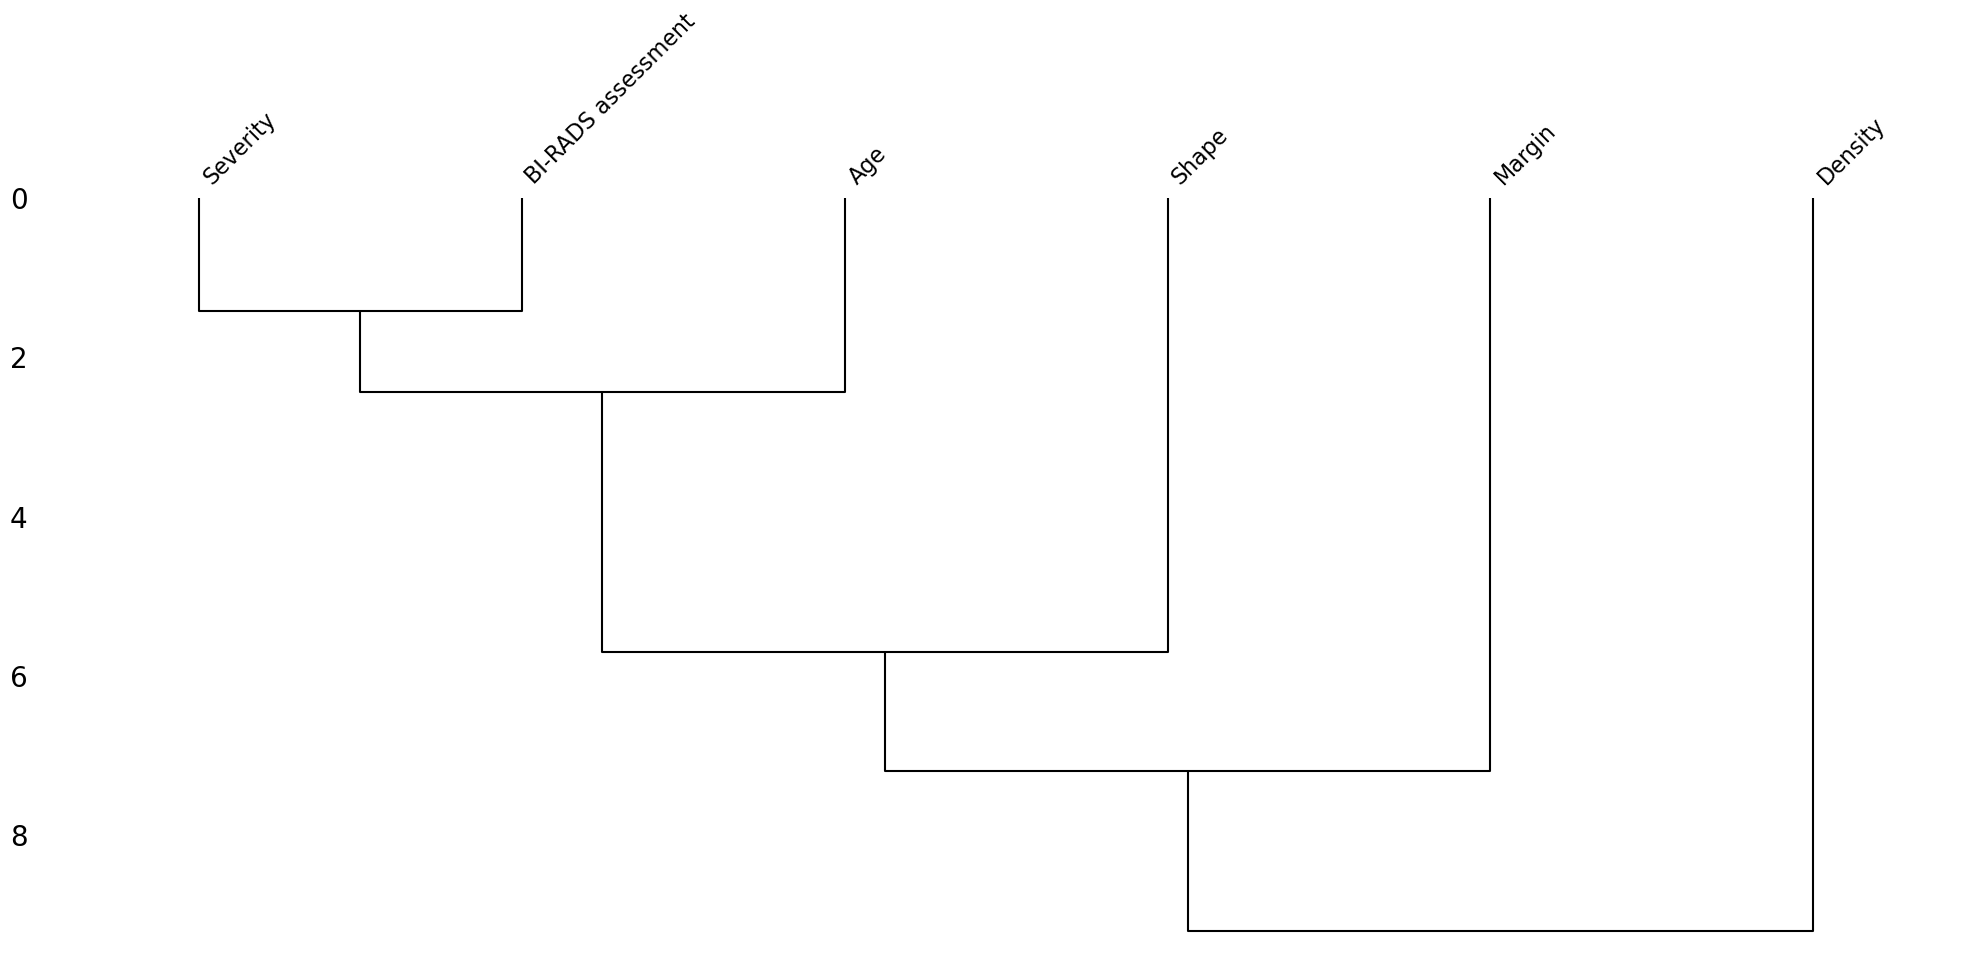

In [99]:
msno.dendrogram(df)

In [101]:
df.drop(columns='BI-RADS assessment', inplace=True)

In [105]:
df

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.000000,1
1,43.0,1.0,1.0,2.910227,1
2,58.0,4.0,5.0,3.000000,1
3,28.0,1.0,1.0,3.000000,0
4,74.0,1.0,5.0,2.910227,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.000000,0
957,56.0,4.0,5.0,3.000000,1
958,64.0,4.0,5.0,3.000000,0
959,66.0,4.0,5.0,3.000000,1


In [107]:
highly_corr_imputed_columns = ['Shape', 'Margin'] 

df.dropna(subset=['Age'], inplace=True)

#highly correlated 0.74
knn_imputer = KNNImputer(n_neighbors=5)

df[highly_corr_imputed_columns] = knn_imputer.fit_transform(df[highly_corr_imputed_columns])
df['Density'] = knn_imputer.fit_transform(df[['Density']])

In [109]:
df.isnull().sum()

Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [111]:
x = df.drop(columns='Severity')
y = df['Severity']

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [115]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [117]:
decision_tree = DecisionTreeClassifier()

decision_tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [119]:
y_pred = decision_tree.predict(x_test)

In [121]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[75 21]
 [27 69]]
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        96
           1       0.77      0.72      0.74        96

    accuracy                           0.75       192
   macro avg       0.75      0.75      0.75       192
weighted avg       0.75      0.75      0.75       192



## Bonus Task - GridSearchCV

To achieve the required split of the dataset into three sets (train set, validation set, and test set) in a ratio of 70:10:20, you can follow these steps: 
- Start by splitting the dataset into a ratio of 80:20 to create the initial train and test sets.
- Subsequently, divide the initial train set further into a ratio of 87.5:12.5 to generate the final train and validation sets.

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train,y_train, test_size=0.125)

In [143]:
scaler = StandardScaler()

x_train_val = scaler.fit_transform(x_train_val)
x_test_val = scaler.transform(x_test_val)

In [145]:
param_grid = {
    'max_depth' : [3, 5],
    'criterion' : ["gini", "entropy", "log_loss"], 
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train_val, y_train_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [147]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5)
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.7709796880260352


In [151]:
best_model = grid_search.best_estimator_

y_pred_val = best_model.predict(x_test_val)

In [153]:
print(classification_report(y_test_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        43
           1       0.91      0.75      0.82        53

    accuracy                           0.82        96
   macro avg       0.83      0.83      0.82        96
weighted avg       0.84      0.82      0.82        96

